<h1>Chapter 4 - Linear Regression</h1> 

<h2>Table of Contents</h2>
<p>In this lab, we will learn 

<ol>
    <li>Training the Linear regression model using basic functions.</li>
    <li>Training the Linear regression model using pytorch functionalities.</li>
</ol>
Further, in sub-chapter 2 we will learn,
<ul>
    <li>Using class <b>nn.Linear</b> to make prediction.</li>
    <li>Building custom classes using <b>nn.Module</b>.</li>
    <li>Using <b><code>DataLoader object</code></b> to implement <b>batch / stochastic / mini-batch gradient descent</b>.
    <li>Using <b><code>optim object</code></b> to train the parameters.</li>
    <li>To select the best learning rate by using validation data by:</li>
    <ol>
        <li><b>Different learning rates and Data Structures to Store results for Different Hyperparameters.</b></li>
        <li><b>Train different modules for different Hyperparameters.</b></li>
    </ol>
</ul>

In linear regression, a linear equation is used to make prediction: $w^T x + b$

The weights (or slope of the line) and bias (or intercept of the line) are trained to fit the training data.

In [1]:
# Import libraries we need for this lab, and set the random seed

from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from torch import nn,optim

<!--Empty Space for separating topics-->

<h3 id="Makeup_Data">Make Some Data</h3>

First, we'll create some artificial data in a dataset class. The class will include the option to produce training data or validation data. The training data will include outliers. The input is of single dimension.

In [2]:
# Create Data class

from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    
    # Constructor
    def __init__(self, train = True):
            self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
            self.f = -3 * self.x + 1                           #Target label
            self.y = self.f + 0.1 * torch.randn(self.x.size()) #Adding noise to create final target label
            self.len = self.x.shape[0]
            
            #outliers 
            if train == True:
                self.y[0] = 0
                self.y[50:55] = 20                             #Adding outliers to training data
            else:
                pass
      
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

Create two objects: one that contains training data and a second that contains validation data. Assume that the training data has the outliers.

In [3]:
# Create training dataset and validation dataset

train_data = Data()             #Returns training data that has outliers
val_data = Data(train = False)  #Returns validation data which doesn't have outliers

Overlay the training points in red over the function that generated the data. Notice the outliers at x=-3 and around x=2:

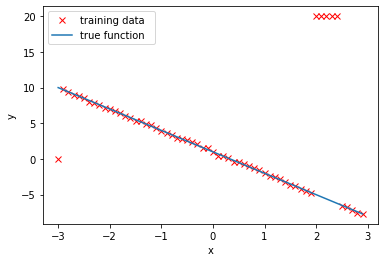

In [4]:
# Plot out training points

plt.plot(train_data.x.numpy(), train_data.y.numpy(), 'xr',label="training data ")
plt.plot(train_data.x.numpy(), train_data.f.numpy(),label="true function  ")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<h2> Training the Linear regression model using basic functions. </h2>

In this section, let us create the model and the cost function (total loss) we are going to use to train the model and evaluate the result.

First, define the <code>forward</code> function $y=w*x$. (without bias)

In [5]:
# Create forward function for prediction
def forward(x):
    return w * x + b

Define the <b>cost or criterion function</b> using MSE (Mean Square Error): 

In [6]:
# Create the MSE function for evaluate the result.
def criterion(yhat, y):
    return torch.mean((yhat - y) ** 2)

Define the learning rate <code>lr</code> and an empty list <code>LOSS</code> to record the loss for each iteration:   

In [7]:
# Create Learning Rate and an empty list to record the loss for each iteration
lr = 0.1
LOSS = []

Now, we create a model parameter by setting the argument <code>requires_grad</code> to <code> True</code> because the system must learn it.

In [8]:
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:

<Figure size 432x288 with 0 Axes>

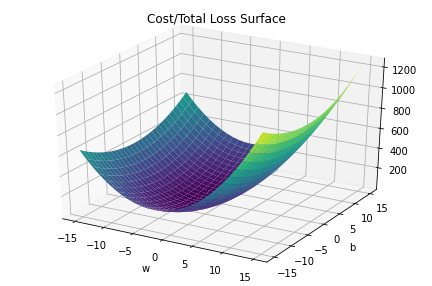

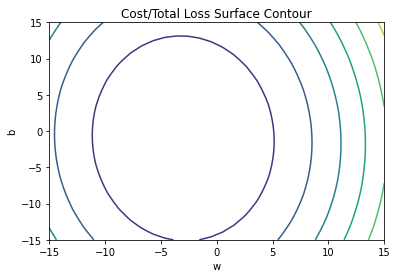

In [9]:
# The class for plot the diagram
class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30,30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1,cmap = 'viridis', edgecolor = 'none')
            plt.title('Cost/Total Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Cost/Total Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
    
    # Setter
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1
        self.W.append(W)
        self.B.append(B)
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W,self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure()
        plt.contour(self.w,self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))

        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Total Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

X = val_data.x  #Without outliers data needed. Hence val_data used. It has nothing to do with validation.
Y = val_data.y

# Create plot_error_surfaces for viewing the data
get_surface = plot_error_surfaces(15, 15, X, Y, 30)

<b>Train the Model</b>

Let us define a function for training the model. The steps will be described in the comments.

Run 15 iterations of gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space 

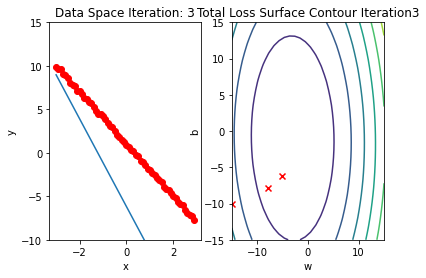

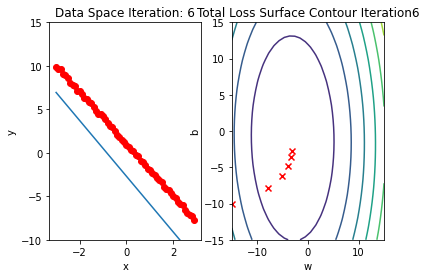

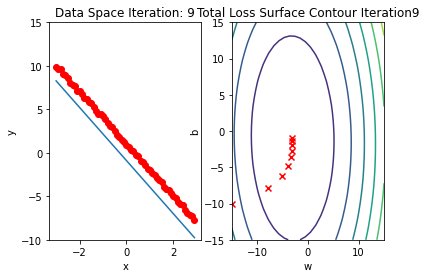

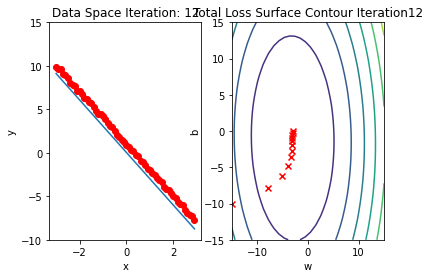

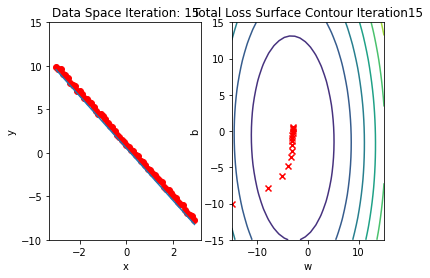

In [10]:
# Define a function for train the model

def train_model(iter):
    
    # Loop
    for epoch in range(iter):
        
        # make a prediction
        Yhat = forward(X)
        
        # calculate the loss 
        loss = criterion(Yhat, Y)

        # Section for plotting
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        if ((epoch+1) % 3) == 0:
            get_surface.plot_ps()
            
        # store the loss in the list LOSS
        LOSS.append(loss)
        
        # backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        
        # update parameters slope and bias
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        
        # zero the gradients before running the backward pass
        w.grad.data.zero_()
        b.grad.data.zero_()
        
# Give 3 iterations for training the model here.
train_model(15)

Plot the cost for each iteration: 

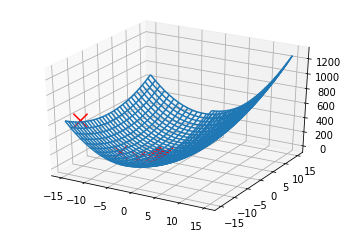

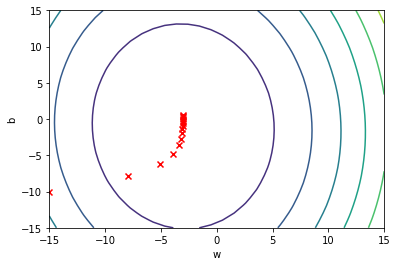

Text(24.125, 0.5, 'Cost')

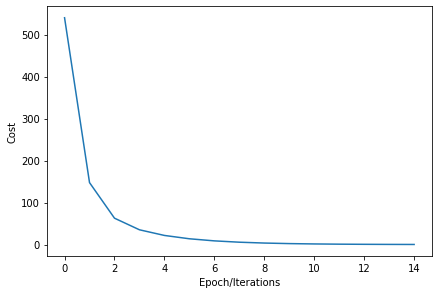

In [11]:
# Plot out the Loss Result
get_surface.final_plot()
plt.plot(LOSS)
plt.tight_layout()
plt.xlabel("Epoch/Iterations")
plt.ylabel("Cost")

<!--Empty Space for separating topics-->

<h2 id="LR_Loader_Cost">Training the Linear regression model using pytorch functionalities.</h2>

Here we will introduce how to use <b>nn.Linear</b> to make prediction.

<b>Using nn.Linear :</b>
<ul>
    <li>The nn.Linear performs the operation $w^T x + b$ in the background.</li>
    <li>It automatically initialises the weights and bias using pytorch internal mechanism. (which will be discussed in later chapters)</li>
    <li>The <code>parameters()</code> method can be used to view nn.Linear parameters.</li>
    <li>A method <code>state_dict()</code> returns a Python dictionary object corresponding to the layers of each parameter tensor.</li>
    <li>It accepts two arguments: the dimension of input data and the number of outputs.</li>
</ul>    

In [12]:
from torch import nn

lnr = nn.Linear(in_features=1, out_features=1, bias=True)
print("Parameters w and b: ", list(lnr.parameters()))
print("Python dictionary: ",lnr.state_dict())
print("keys: ",lnr.state_dict().keys())
print("values: ",lnr.state_dict().values())
print("weight:",lnr.weight)
print("bias:",lnr.bias)

Parameters w and b:  [Parameter containing:
tensor([[0.9857]], requires_grad=True), Parameter containing:
tensor([0.0634], requires_grad=True)]
Python dictionary:  OrderedDict([('weight', tensor([[0.9857]])), ('bias', tensor([0.0634]))])
keys:  odict_keys(['weight', 'bias'])
values:  odict_values([tensor([[0.9857]]), tensor([0.0634])])
weight: Parameter containing:
tensor([[0.9857]], requires_grad=True)
bias: Parameter containing:
tensor([0.0634], requires_grad=True)


Next, we introduce <b>nn.Module</b> to create custom class to perform prediction using <b>nn.Linear</b>.

<b>Using nn.Module :</b>
<ul>
    <li>We create a custom class <code>linear_regression</code> by inheriting the class <code>nn.Module</code>.</li>
    <li>The inbuilt function <code>super()</code> is used to call the constructor of the base class.</li>
    <li>Further <code>forward()</code> function is used to make the prediction using <code>nn.Linear</code>.</li>
</ul>

In [13]:
# Create Linear Regression Class
class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # Prediction function
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

Here, the criterion / cost / loss function is created used pytorch built-in function <code>nn.MSELoss()</code> (Mean Square Loss). 

Also, a <code>DataLoader</code> object is created to implement batch / stochastic / mini-batch gradient descent. The <code>DataLoader</code> takes 2 arguments. The 1st argument is the data that will be divided into batches. The 2nd argument is the batch size. 

<b> Note: Which one of batch / stochastic / mini-batch gradient descent is used depends upon the batch size.</b>
<ul>
    <li><b>Gradient descent / Batch gradient descent:</b> batch_size = entire training data</li>
    <li><b>Stochastic gradient descent:</b> batch_size = 1</li>
    <li><b>Mini-batch gradient descent:</b> 1 $<$ batch_size $<$ entire training data</li>
</ul>

<h3><b>Stochastic gradient descent:</b></h3>
<ul>
    <li>Here, the parameters are minimized with respect to just one sample at a time. We actually approximate the cost or minimize the sum or average loss of each sample.</li>
    <li>The value of the approximate cost will fluctuate rapidly with each iteration.</li>
    <li>In every epoch, we run stochastic gradient descent for each sample.</li>
    <code>DataLoader(dataset = train_data, batch_size = 1)</code>
</ul>

<h3><b>Mini-batch gradient descent:</b></h3>
<ul>
    <li>One important advantage is that it will allow you to process larger datasets, that you will not be able to fit into memory, as it splits up the dataset into smaller samples.</li>
    <li>In Mini-Batch Gradient Descent we use a few samples at a time for each iteration.</li>
    <li>In every epoch, we run mini-batch gradient descent for each mini-batch.</li>
    <code>DataLoader(dataset = train_data, batch_size = 5)</code> implements mini-batch of size 5.
</ul>

Here, we have used stochastic gradient descent.

In [19]:
# Create MSELoss function and DataLoader
criterion = nn.MSELoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)

<!--Empty Space for separating topics-->

<h2 id="LR_Hyper">Different learning rates and Data Structures to Store results for different Hyperparameters</h2>

Create a list with different learning rates and a tensor (can be a list) for the training and validating cost/total loss. Include the list MODELS, which stores the training model for every value of the learning rate. 

In [15]:
# Create Learning Rate list, the error lists and the MODELS list

learning_rates=[0.0001, 0.001, 0.01, 0.1]

train_error=torch.zeros(len(learning_rates))
validation_error=torch.zeros(len(learning_rates))

MODELS=[]

<!--Empty Space for separating topics-->

<h2 id="Model">Train different models  for different Hyperparameters</h2>

Try different values of learning rates, perform stochastic gradient descent, and save the results on the training data and validation data. Finally, save each model in a list.

<b>Using <code>optim object</code>: </b>
<ul>
    <li>Here we use the <code>optim object</code> to train the parameters (weight and bias) using stochastic gradient descent: <code> optim.SGD(model.parameters(), lr = lr) </code> </li>
    <li>Remember to construct an optimizer you have to give it an iterable containing the parameters i.e. provide <code> model.parameters()</code> as an input to the object constructor. </li>
    <li>Similar to the model, the optimizer has a state dictionary which can be accessed using:
    <code>optimizer.state_dict()</code></li>
</ul>

<b> Note: PyTorch randomly initialises your model parameters. We can ourselves initialise the parameters using, </b>
<code>
model.state_dict()['linear.weight'][0] = -15
model.state_dict()['linear.bias'][0] = -10
</code>

In [16]:
# Define the train model function and train the model

def train_model_with_lr (iter, lr_list):
    
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        model = linear_regression(1, 1)
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):
            for x, y in trainloader:
                yhat = model(x) #model(x) executes the forward() function of the custom class linear_regression
                loss = criterion(yhat, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # train data
        Yhat = model(train_data.x)
        train_loss = criterion(Yhat, train_data.y)
        train_error[i] = train_loss.item()
    
        # validation data
        Yhat = model(val_data.x)
        val_loss = criterion(Yhat, val_data.y)
        validation_error[i] = val_loss.item()
        MODELS.append(model)

train_model_with_lr(10, learning_rates)

<!--Empty Space for separating topics-->

<h2 id="Result">View the Results</h2>

Plot the training loss and validation loss for each learning rate:  

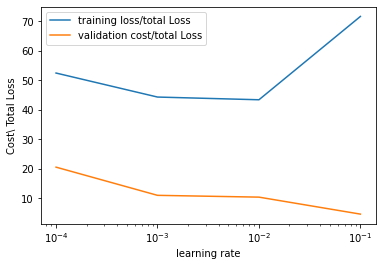

In [17]:
# Plot the training loss and validation loss

plt.semilogx(np.array(learning_rates), train_error.numpy(), label = 'training loss/total Loss')
plt.semilogx(np.array(learning_rates), validation_error.numpy(), label = 'validation cost/total Loss')
plt.ylabel('Cost\ Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

Produce a prediction by using the validation data for each model:  

i [[1.6452477]
 [1.6028745]
 [1.5605011]]
i [[5.443075 ]
 [5.3272667]
 [5.211458 ]]
i [[6.6205835]
 [6.4853973]
 [6.35021  ]]
i [[14.048926]
 [13.628894]
 [13.20886 ]]


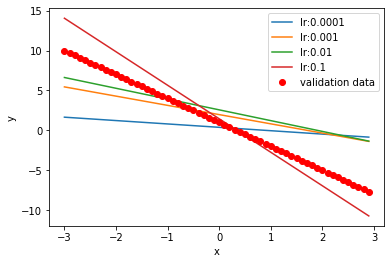

In [18]:
# Plot the predictions

i = 0
for model, learning_rate in zip(MODELS, learning_rates):
    yhat = model(val_data.x)
    plt.plot(val_data.x.numpy(), yhat.detach().numpy(), label = 'lr:' + str(learning_rate))
    print('i', yhat.detach().numpy()[0:3])
plt.plot(val_data.x.numpy(), val_data.f.numpy(), 'or', label = 'validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()